<a href="https://colab.research.google.com/github/kindustrii/doiit-bildklassifizierung/blob/main/doiit_bildklassifizierung_teil_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Ich verwende hier für den Entwurf und das Training des Netzes ausschließlich die TensorFlow (TF) Bibliotheken, bzw. die von TF integrierte High level API Keras.

Auf die Matplotlib Programmbibliothek greifen wir zurück um uns Bilder und Grafiken anzeigen zu lassen. Und tensorflow_datasets bietet uns die Möglichkeit verschiedene Datensätze zu laden und zu verarbeiten. 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
ds, info = tfds.load('imagenette/160px-v2', with_info=True,as_supervised=True, shuffle_files=True)

Shuffling and writing examples to /root/tensorflow_datasets/imagenette/160px-v2/0.1.0.incomplete45KJTB/imagenette-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/160px-v2/0.1.0.incomplete45KJTB/imagenette-validation.tfrecord


Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/160px-v2/0.1.0. Subsequent calls will reuse this data.


Neben dem Datensatz, haben wir uns noch die dazugehörenden Informationen geladen. Diese lassen wir uns mit dem Aufruf von print(info) anzeigen.

Nach dem Aufruf der print-Methode erhalten wir die untere Ausgabe. Wir interessieren uns an dieser Stelle nur für wenige wichtige Informationen:

 

*   ListeneintraAn Image(shape=(None, None, 3) erkennen wir, dass die im Datensatz enthaltenen Bilder unterschiedliche Größen aufweisen.
*   Durch num_classes=10 wissen wir, dass alle Bilder zu 10 Klassen, bzw. Kategorien gehören.
*   total_num_examples=13394 gibt die Anzahl der Bilder an.
*   Außerdem sind die Bilder bereits in “train” und “validation” aufgeteilt und enthalten 9469 bzw. 3925 Bilder.

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='imagenette',
    version=0.1.0,
    description='Imagenette is a subset of 10 easily classified classes from the Imagenet
dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
behind putting together a small version of the Imagenet dataset was mainly
because running new ideas/algorithms/experiments on the whole Imagenet take a
lot of time.

This version of the dataset allows researchers/practitioners to quickly try out
ideas and share with others. The dataset comes in three variants:

  * Full size
  * 320 px
  * 160 px

Note: The v2 config correspond to the new 70/30 train/valid split (released
in Dec 6 2019).',
    homepage='https://github.com/fastai/imagenette',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=13394,
    splits={
        'train': 9469,
        'validation': 3925,
    }

Wie üblich teilen wir die Daten in zwei Sets auf, und zwar in Training-Set und und Test-Set. Das erstere wird wie der Name schon sagt für das Trainieren des Netzes verwendet und das letztere wird vor der KI versteckt und später als unbekanntes Set für das Testen und Validieren gebraucht.

In [3]:
train_data, test_data = ds['train'], ds['validation']

Um sicher zu gehen, dass die Aufteilung wie gewünscht funktioniert hat, prüfen wir noch ob die Anzahl der Bilder in den Sets mit den Angaben in der Info zum Datensatz übereinstimmt.

In [4]:
print('Anzahl Bilder im Training-Set: ', len(train_data))
print('Anzahl Bilder im Test-Set: ', len(test_data))

Anzahl Bilder im Training-Set:  9469
Anzahl Bilder im Test-Set:  3925


Wenn wir uns schon mit den Bildern beschäftigen, schreiben wir noch eine kleine Funktion plot_images(), mit der wir uns nachher die Bilder anzeigen lassen können.

In [5]:
def plot_images(data, size=(20,20)):
  ''' 
  Funktion zum Anzeigen der Bilder aus dem Dataset
  '''
  plt.figure(figsize=size)
  for i in range(25):
    for img, label in data.take(i+1):
      plt.subplot(5, 5, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(True)
      plt.imshow(img, cmap=plt.cm.binary)
      plt.title(my_class_names[label])
      plt.ylabel(img.shape)
  plt.show()

Zum Schluss interessieren wir uns noch für die 10 Klassen, denen die Bilder zugeordnet sind. Wir lassen und diese mit print(info.features[‘label’].names) und stellen überraschend fest, dass wir mit diesen Bezeichnungen nichts anfangen können.

Es bleibt nichts anderes übrig, als sich die Bilder anzusehen und die Klassenbezeichnung händisch zu ermitteln. Das habe ich bereits getan und verwende weiter unten in meinem Code sinnvollere Bezeichnungen. Diese Bezeichnungen sind in der Liste my_class_names zu finden.

In [6]:
print(info.features['label'].names)

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [6]:
# Von Hand ermittelte Bezeichnung, die wir im Code verwenden werden
my_class_names = ['Fisch', 'Hund', 'Kassettenspieler', 'Kettensaege', 'Kirche', 'Horn', 
                  'Muellwagen', 'Zapfsaeule', 'Golfball', 'Fallschirm']

Wir haben oben festgestellt, dass sich die Bilder in dem Datensatz hinsichtlich der Größe unterscheiden. Das bedeutet wir müssen alle Bilder auf die gleiche Größe bringen, damit diese von unserem Netz verarbeitet werden können.

Dafür gibt er verschiedene Möglichkeiten, die wir uns noch in den folgenden Teilen der Reihe ansehen werden. Eine gängige Variante ist es z.B. die Anpassung der Bilder in der ersten Schicht des Netzes vorzunehmen. Das hat den Vorteil, dass das Modell dann ohne zusätzlichen Code implementiert werden kann.

Wir machen das hier aber außerhalb des Netzes, da es auf diese Weise etwas anschaulicher ist.

# Original Bilder

Mit dem folgenden Code werfen wir einen Blick auf die Größe der ersten 5 Bilder. Unten siehst Du die Ausgabe mit fünf Zeilen. Jede Zeile enthält Informationen zu jeweils einem Bild. 

Am Anfang jeder Zeile findet sich eine Klammer, in der drei Zahlen enthalten sind. Diese Zahlen repräsentieren in der Form (Höhe, Breite, Farbkanäle) die Größe des jeweiligen Bildes. Der Farbkanal hat in diesem Fall immer den Wert 3. Das bedeutet es handelt sich um Farbige Bilder.

In [8]:
for img, label in train_data.take(5):
  print(img.shape,label)

(160, 213, 3) tf.Tensor(6, shape=(), dtype=int64)
(160, 238, 3) tf.Tensor(7, shape=(), dtype=int64)
(160, 198, 3) tf.Tensor(2, shape=(), dtype=int64)
(160, 186, 3) tf.Tensor(3, shape=(), dtype=int64)
(160, 222, 3) tf.Tensor(4, shape=(), dtype=int64)


Hier findest Du Beispielhaft ein Bild aus dem Datensatz dargestellt. Über dem Bild habe ich noch zusätzlich die jeweilige Klassenbezeichnung und links die Größe des Bildes ergänzt. 

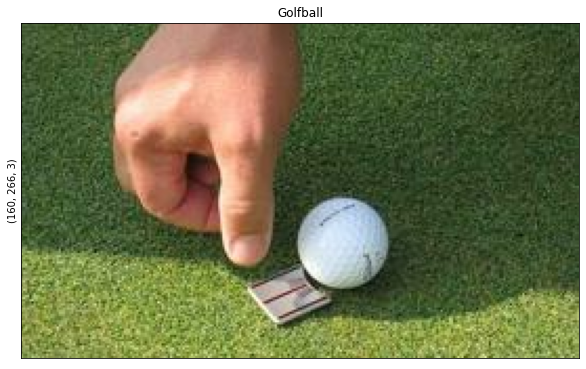

In [24]:
plt.figure(figsize=(10, 10))
for img, label in train_data.take(30):
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title(my_class_names[label],)
    plt.ylabel(img.shape)
plt.show()

Unten sind weitere 25 Bilder nebeneinander dargestellt, so dass schon auf den ersten Blick starke unterscheide in der Größe zu erkennen sind.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


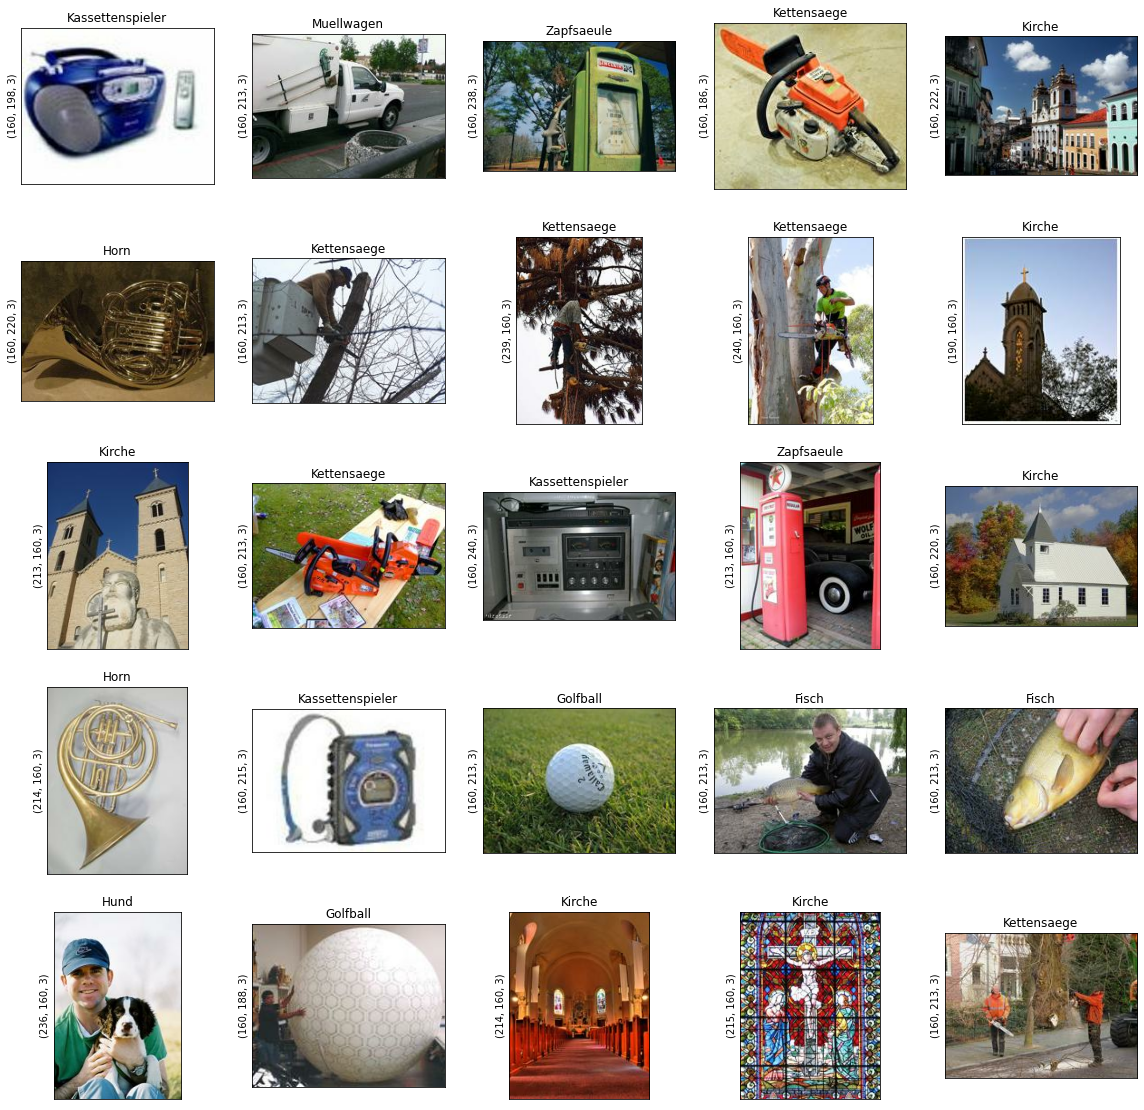

In [7]:
# Die ersten 25 Bilder in Originalgroesse darstellen
plot_images(train_data)

# Anpassung der Bilder

Wir werden zwei Anpassung an den Bildern vornehmen. Zunächst passen wir die Größe aller Bilder auf (160,160, 3). Zusätzlich werden wir noch die Pixelwerte jedes Bildes Normalisieren, so dass sich diese alle in einem Bereich zw. 0 und 1 befinden.

Normalerweise liegt der Wert eines Pixels zw. 0 und 255 (RGB Farbwerte), aber die neuronalen Netze rechnen lieber mit Werten zw. 0 und 1, weshalb wir jeden Pixelwert einfach durch 255 teilen werden.

In [19]:
IMG_SIZE = 160

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [20]:
# Bearbeitung des Training-Set
train_data_rs = train_data.map(
  lambda x,y: (resize_and_rescale(x, training=True),y))

In [21]:
# Bearbeitung des Test-Set
test_data_rs = test_data.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

Werfen wir jetzt einen Blick auf die gleichen Bilder wie vorher, stellen wir fest, dass diese jetzt alle gleich groß sind.

In [22]:
for img, label in train_data_rs.take(5):
  print(img.shape,label)

(160, 160, 3) tf.Tensor(2, shape=(), dtype=int64)
(160, 160, 3) tf.Tensor(6, shape=(), dtype=int64)
(160, 160, 3) tf.Tensor(7, shape=(), dtype=int64)
(160, 160, 3) tf.Tensor(3, shape=(), dtype=int64)
(160, 160, 3) tf.Tensor(4, shape=(), dtype=int64)


Auch optisch ist auf den ersten Blick erkennbar, dass die 25 Bilder die wir uns vorhin angesehen haben, gleich groß geworden sind. 

Die Trainingsdaten sind jetzt vorbereitet und wir können uns an die Arbeit machen ein passendes neuronales Netz dazu entwerfen.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


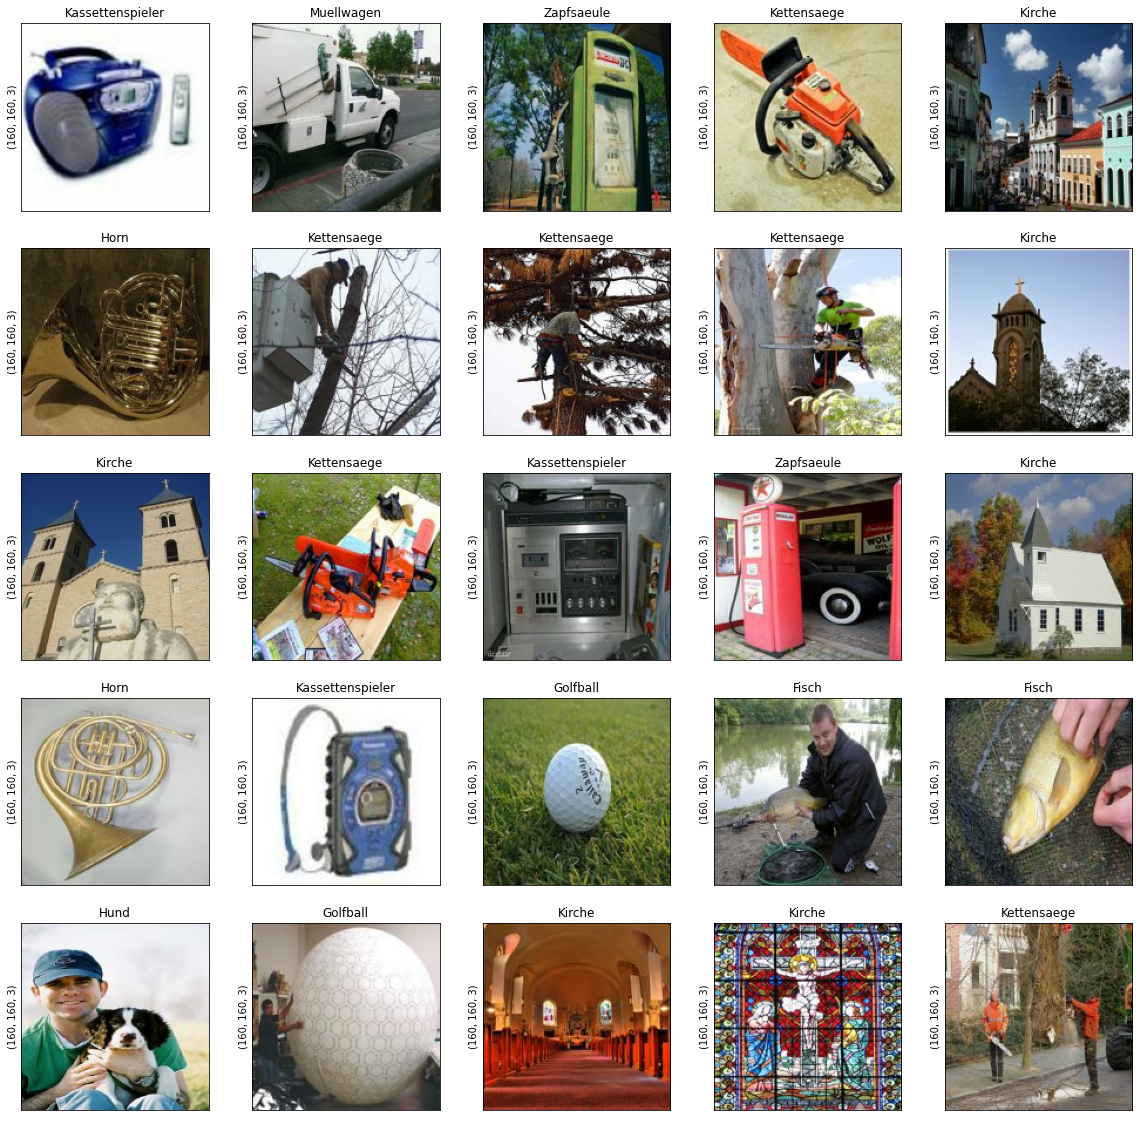

In [23]:
# Die ersten 25 Bilder mit geaenderter Groesse darstellen
plot_images(train_data_rs)

# CNN - Modell

Wir erstellen ein ganz einfaches CNN-Modell, das nur aus den notwendigsten Schichten besteht und keinerlei Optimierungen erfahren hat. In der Realität sind die Modelle deutlich komplexer, also lass Dich bitte nicht von der Einfachheit hier täuschen. Aber egal wie komplex diese Modelle auch sein mögen, sie basieren alle auf den gleichen Komponenten, wir unser kleines CNN.

Kennzeichnend für ein CNN ist, dass neuronale Netz über die inneren Schichten Conv2D und MaxPooling2D verfügt. Hier im ersten Teil möchte ich nicht weiter auf diese beiden Schichten (engl. Layer) eingehen. Aber wir werden uns noch of mit denen beschäftigen und auseinandersetzen. 

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(160,160,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')])

Das war es auch schon mit dem Entwerfen der Architektur für unser CNN. Die oberen 10 Zeilen Code ist die KI, wenn Du so willst. Alles andere was wir bisher getan haben, war nur Datenvorbereitung. (Natürlich verbergen sich hinter jeder dieser Zeilen Code, 100-tausende weitere Zeilen Code. Aber diese Arbeit wurde für uns zum Glück schon erledigt, so dass wir selber nicht mehr so viel Code schreiben müssen). 

Mit model.summary() können wir uns noch einmal vergewissern, dass die Schichten und Parameter unserer Vorstellung entsprechen.

In [26]:
# Zusammenfassung des Modells ausgeben inkl. aller Schichten und Parameter
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)            

# Training

Bevor wir das obere Modell trainieren, fassen wir noch unsere Daten zu Batches mit je 32 Bildern zusammen. Der Training Algorithmus ist so aufgebaut, dass zunächst ein ganzes Batch durch das Netz geschickt wird, daraus ein durchschnittlicher Fehler berechnet und mit diesem die Anpassung der Gewichte durchgeführt wird.

Es gibt auch die Möglichkeit eine Gewichtsanpassung nach jedem einzelnen Bild vorzunehmen. Es hat sich aber bewährt das Training mit Batches durchzuführen, da es auf diese Weise deutlich effizienter ist.

In [27]:
# Bilder des Training-Set in Batches zusammenfassen
train_data_rs = train_data_rs.batch(32)
# Bilder des Test-Set in Batches zusammenfassen
test_data_rs = test_data_rs.batch(32)

Versuchen wir jetzt uns die 5 Bilder anzuzeigen, wie wir es bereits zwei mal getan haben, dann stellen wir fest, dass die erste Klammer noch die Zahl 32 hinzubekommen hat.

Wir bekommen jetzt nämlich nicht mehr die 5 Bilder angezeigt, sonder 5 Batches, mit je 32 Bildern. Die Werte innerhalb der Klammer bedeuten jetzt (Anzahl Bilder, Höhe, Breite, Farbkanäle).

In [28]:
for img, label in train_data_rs.take(5):
  print(img.shape,label)

(32, 160, 160, 3) tf.Tensor([2 6 3 7 4 5 3 3 3 4 4 3 2 7 4 5 2 8 0 0 1 8 4 4 3 6 9 8 4 8 0 8], shape=(32,), dtype=int64)
(32, 160, 160, 3) tf.Tensor([1 6 5 9 8 4 8 0 6 0 0 9 9 1 1 5 0 0 9 4 5 4 3 1 2 9 3 6 0 7 4 4], shape=(32,), dtype=int64)
(32, 160, 160, 3) tf.Tensor([7 3 4 7 2 0 5 3 4 2 2 9 0 5 4 4 3 6 0 4 7 6 4 5 5 8 4 7 3 2 5 0], shape=(32,), dtype=int64)
(32, 160, 160, 3) tf.Tensor([4 2 0 1 5 4 4 1 8 2 4 4 8 1 5 0 1 7 6 9 8 5 7 6 3 7 7 5 0 8 9 7], shape=(32,), dtype=int64)
(32, 160, 160, 3) tf.Tensor([5 9 8 3 6 6 3 1 6 6 7 5 0 9 9 8 3 6 8 0 2 3 4 8 0 1 3 7 4 4 0 8], shape=(32,), dtype=int64)


Hier wird das Model Compiliert…

In [29]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

… und hier starten wird das Training.

Das Training im Detail ist für uns jetzt erstmal uninteressant, da wir hier im ersten Teil der Reihe nur einen End-to-End Durchlauf haben wollten. Und nun sind wir schon fast am Ende angekommen. Ganz unten kannst Du noch das Ergebnis bzw. die Auswertung des Trainings finden.

Mehr Details zum Training und wie dieses optimiert und das Ergebnis verbessert werden kann, sehen wir uns noch in den kommenden Beiträgen an.

In [30]:
history = model.fit(train_data_rs,epochs=10,validation_data=test_data_rs)

Epoch 1/10
296/296 [==============================] - 19s 38ms/step - loss: 2.1123 - accuracy: 0.2447 - val_loss: 1.6949 - val_accuracy: 0.4285
Epoch 2/10
296/296 [==============================] - 8s 28ms/step - loss: 1.6129 - accuracy: 0.4600 - val_loss: 1.5169 - val_accuracy: 0.5009
Epoch 3/10
296/296 [==============================] - 8s 28ms/step - loss: 1.4374 - accuracy: 0.5243 - val_loss: 1.4440 - val_accuracy: 0.5236
Epoch 4/10
296/296 [==============================] - 8s 28ms/step - loss: 1.3243 - accuracy: 0.5687 - val_loss: 1.3790 - val_accuracy: 0.5422
Epoch 5/10
296/296 [==============================] - 8s 28ms/step - loss: 1.2252 - accuracy: 0.6066 - val_loss: 1.3206 - val_accuracy: 0.5659
Epoch 6/10
296/296 [==============================] - 8s 28ms/step - loss: 1.1363 - accuracy: 0.6388 - val_loss: 1.2663 - val_accuracy: 0.5842
Epoch 7/10
296/296 [==============================] - 8s 28ms/step - loss: 1.0556 - accuracy: 0.6684 - val_loss: 1.2324 - val_accuracy: 0.604

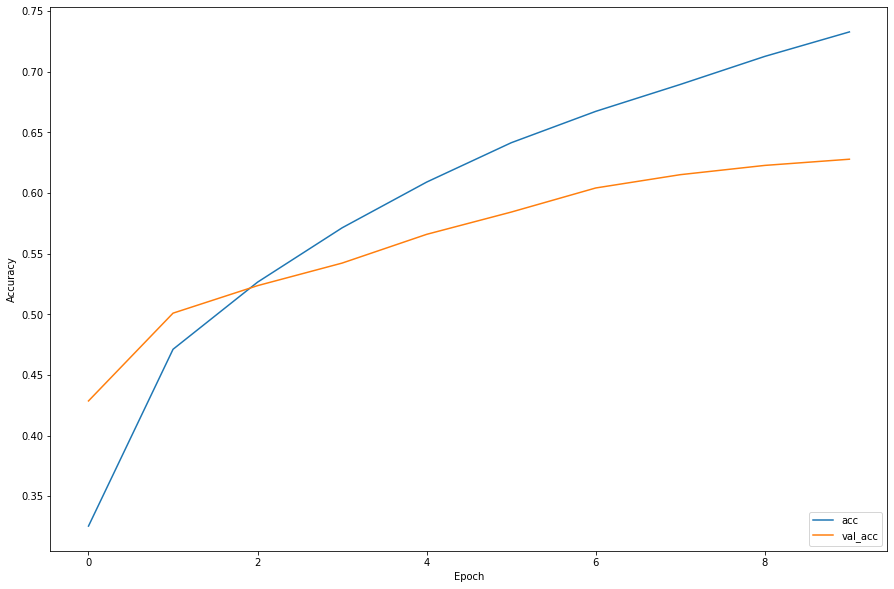

In [34]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Der untere Wert 0.628 bedeutet, dass unsere KI mit einer Genauigkeit von 62,8 % bei der Klassifizierung eines Bildes richtig liegt. 

BEACHTE: Wir haben 10 Klassen, denen ein Bild zugeordnet werden kann. Wenn die KI es nur zufällig richtig gemacht hätte, dann müsste der Wert irgendwo bei 10% liegen und nicht wie manche vielleicht vermuten bei 50%.

So auf die schnelle und ohne viel Aufwand ist das eigentlich ein ganz gute Ergebnis, das sich aber natürlich noch deutlich steigern lässt.

In [39]:
test_acc = model.evaluate(test_data_rs, verbose=2)
print('Test accuracy: ',test_acc[1])

123/123 - 2s - loss: 1.1882 - accuracy: 0.6278
Test accuracy:  0.627770721912384
